# Integrate timepoints for Renangioblast population (RNB)

- Last updated: 12/14/2023

In [1]:
library(data.table)
library(dplyr)
library(Seurat)
library(viridis)
library(ggExtra)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Loading required package: viridisLite



In [2]:
library(SeuratData)
library(SeuratDisk)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [3]:
ATLAS_DIR = '/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_renangioblast/'        # Read QC'd h5ad from here 
SCT_ATLAS = '/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_renangioblast/' # Write integrated Atlas (after SCT pipeline) here
ATLAS_FILE  = 'danio_atlas_RNB_annotated.rds'

In [4]:
options(future.globals.maxSize = 6000 * 1024^2) # to avoid memory issues

In [5]:
# # output files 
# OUT_FILE = 'integration_2023.rdata'

In [5]:
setwd(ATLAS_DIR)

In [6]:
RNB.combined <- LoadH5Seurat("umapv2_velocity_subset_renangioblast.h5seurat",
                             assays="RNA")
RNB.combined

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding reduction umap_654d8b39

Adding cell embeddings for umap_654d8b39

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_654d8b39_ to umap654d8b39_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umap654d8b39_”
Adding miscellaneous information for umap_654d8b39

Adding command information

Adding cell-level metadata



An object of class Seurat 
26065 features across 7169 samples within 1 assay 
Active assay: RNA (26065 features, 0 variable features)
 1 dimensional reduction calculated: umap_654d8b39

In [7]:
Idents(RNB.combined) <- "annotation_seuratres1_5_v3"
celltype_counts <- table(Idents(RNB.combined))
print(celltype_counts)


          Erythroid_hbae1_3_hbae1_2      endothelia_cells_sox7_kdrl_yvk 
                               1075                                 582 
   lateral_plate2_hand2_gata5_jam3b     lateral_plate_hand2_gata5_jam3b 
                                360                                1237 
            macrophages_rhogb_spi1b pharyngeal_arch_six1a_twist1a_cdh11 
                                356                                1282 
       pronephric_duct_hnf1bb_cdh17                  somites_msgn1_vwde 
                                507                                1770 


In [8]:
# filter out irrelevant cell-types (identified by Merlin Lange)
unique(RNB.combined@meta.data$annotation_seuratres1_5_v3)
Idents(RNB.combined) <- "annotation_seuratres1_5_v3"

# celltypes to filter out
celltypes_to_filter <- c("pharyngeal_arch_six1a_twist1a_cdh11", "somites_msgn1_vwde")

# subset the Seurat object
RNB_filtered <- subset(RNB.combined, idents = celltypes_to_filter, invert=TRUE)
RNB_filtered

[1] endothelia_cells_sox7_kdrl_yvk      lateral_plate2_hand2_gata5_jam3b   
[3] somites_msgn1_vwde                  Erythroid_hbae1_3_hbae1_2          
[5] pharyngeal_arch_six1a_twist1a_cdh11 pronephric_duct_hnf1bb_cdh17       
[7] macrophages_rhogb_spi1b             lateral_plate_hand2_gata5_jam3b    
8 Levels: Erythroid_hbae1_3_hbae1_2 ... somites_msgn1_vwde

An object of class Seurat 
26065 features across 4117 samples within 1 assay 
Active assay: RNA (26065 features, 0 variable features)
 1 dimensional reduction calculated: umap_654d8b39

In [9]:
saveRDS(RNB_filtered, "/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_renangioblast/RNB_filtered.rds")

In [10]:
# Integration 
print(paste("Split object by timepoint"))
# 1. Split object and process each time point independently 
danio.list = SplitObject(RNB_filtered, split.by='timepoint')

danio.list <- lapply(X = danio.list, FUN = function(x) {
    #x <- NormalizeData(x) # this dataset is already log-normalized
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

features <- SelectIntegrationFeatures(object.list = danio.list)

danio.list <- lapply(X = danio.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})

print(paste("Integration ... "))

[1] "Split object by timepoint"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


[1] "Integration ... "


In [11]:
danio.list

$`30somite`
An object of class Seurat 
26065 features across 2141 samples within 1 assay 
Active assay: RNA (26065 features, 2000 variable features)
 2 dimensional reductions calculated: umap_654d8b39, pca

$`15somite`
An object of class Seurat 
26065 features across 702 samples within 1 assay 
Active assay: RNA (26065 features, 2000 variable features)
 2 dimensional reductions calculated: umap_654d8b39, pca

$`05somite`
An object of class Seurat 
26065 features across 470 samples within 1 assay 
Active assay: RNA (26065 features, 2000 variable features)
 2 dimensional reductions calculated: umap_654d8b39, pca

$`10somite`
An object of class Seurat 
26065 features across 328 samples within 1 assay 
Active assay: RNA (26065 features, 2000 variable features)
 2 dimensional reductions calculated: umap_654d8b39, pca

$`20somite`
An object of class Seurat 
26065 features across 394 samples within 1 assay 
Active assay: RNA (26065 features, 2000 variable features)
 2 dimensional reductions c

In [14]:
# 2. Find integration anchors and integrate data 
danio.anchors <- FindIntegrationAnchors(object.list = danio.list, anchor.features = features,
                                       normalization.method = 'LogNormalize', #c("LogNormalize", "SCT"),
                                       dims = 1:50, # default 1:30
                                       k.anchor = 5, #default 5
                                       k.filter = 200, #default 200 for a query cell, If the anchor reference cell is found within the first k.filter (200) neighbors, then we retain this anchor.
                                       k.score = 30, # default 30: For each reference anchor cell, we determine its k.score (30) nearest within-dataset neighbors and its k.score nearest neighbors in the query dataset
                                       reduction = "rpca", # default cca, rpca should be faster 
                                       reference = c(1,6) 
                                       )
RNB_filtered <- IntegrateData(anchorset = danio.anchors,
                              k.weight = 50)



Scaling features for provided objects

Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1186 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 485 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 576 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1140 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 156 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 178 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 234 anchors

Projecting new data o

In [15]:
RNB_filtered

An object of class Seurat 
28065 features across 4117 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA

In [17]:
# 3. Generate an integrated embedding: run PCA on integrated (corrected) counts 
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(RNB_filtered) <- "integrated"

# Run the standard workflow for visualization and clustering
RNB_filtered <- ScaleData(RNB_filtered, verbose = FALSE)
RNB_filtered <- RunPCA(RNB_filtered, npcs = 100, verbose = FALSE)
print(paste("Runnning UMAP on the integrated PCA embedding..."))

[1] "Runnning UMAP on the integrated PCA embedding..."


In [18]:
# 4. UMAP on integrated embbedding 
RNB_filtered <- RunUMAP(RNB_filtered, reduction = "pca", dims = 1:30,
                         metric='euclidean',
                         n.neighbors = 30,
                         local.connectivity  =1, # 1 default
                         repulsion.strength = 1, # 1 default
                         )
RNB_filtered <- FindNeighbors(RNB_filtered, reduction = "pca", dims = 1:30)
RNB_filtered <- FindClusters(RNB_filtered, resolution = 0.5)



Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:12:18 UMAP embedding parameters a = 0.9922 b = 1.112

14:12:18 Read 4117 rows and found 30 numeric columns

14:12:18 Using Annoy for neighbor search, n_neighbors = 30

14:12:18 Building Annoy index with metric = euclidean, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:12:19 Writing NN index file to temp file /tmp/Rtmpj4YZcH/file530a2772a6edb

14:12:19 Searching Annoy index using 1 thread, search_k = 3000

14:12:24 Annoy recall = 100%

14:12:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbo

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4117
Number of edges: 128969

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8879
Number of communities: 13
Elapsed time: 2 seconds


In [19]:
# 5. Export R object 
saveRDS(RNB_filtered, file = paste0(SCT_ATLAS, "RNB_filtered_seurat_integrated.rds")) 

In [20]:
RNB_filtered

An object of class Seurat 
28065 features across 4117 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

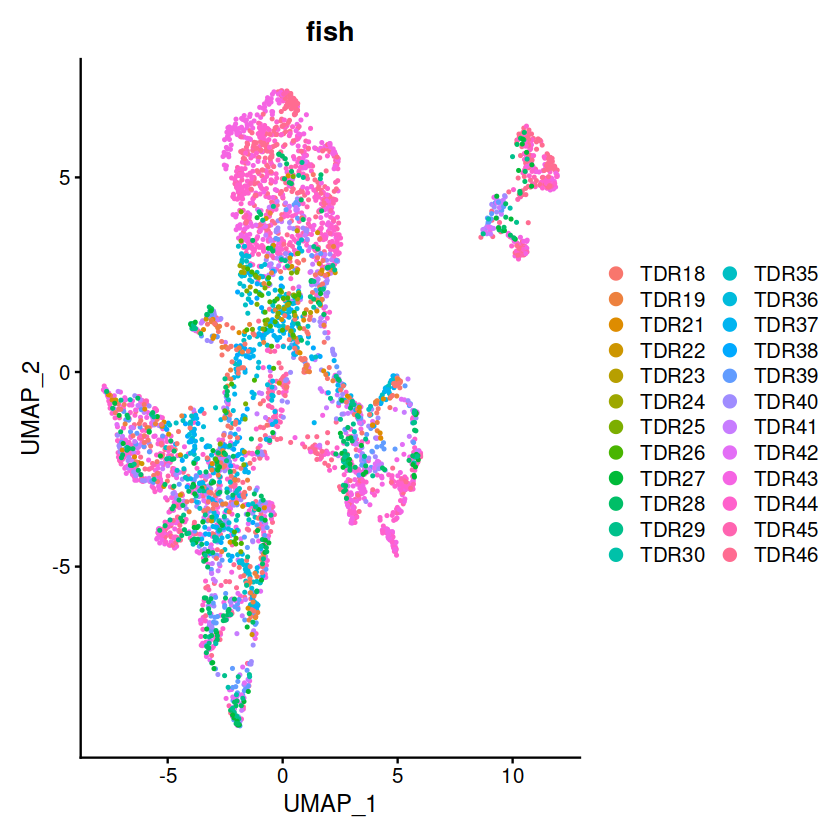

In [21]:
# Check the integrated UMAP
DimPlot(RNB_filtered, dims = c(1, 2), group.by = "fish")

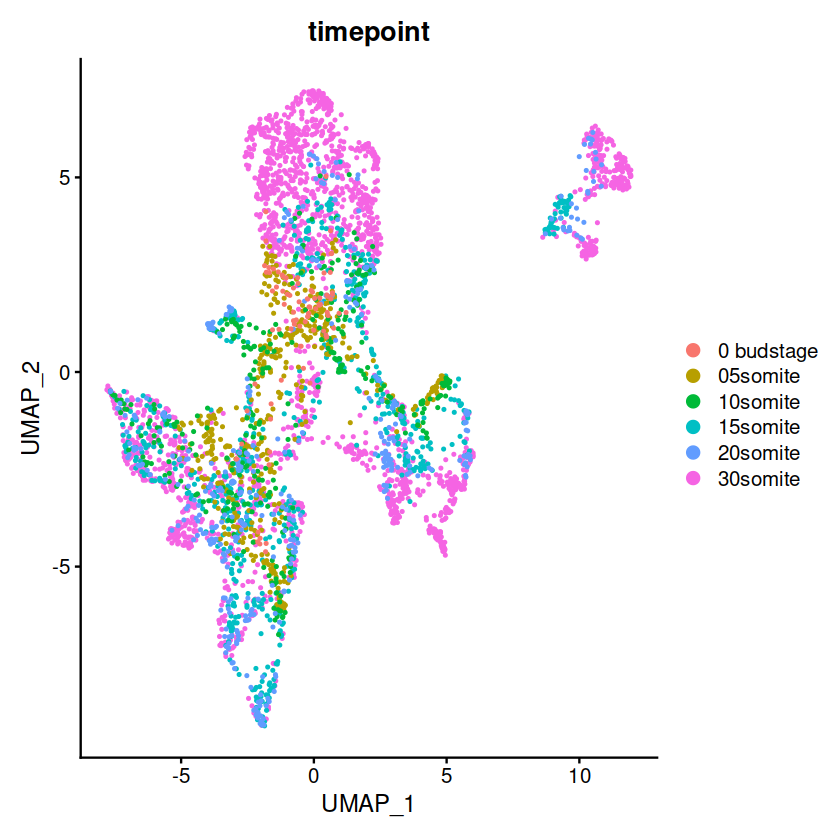

In [22]:
DimPlot(RNB_filtered, dims = c(1, 2), group.by = "timepoint")

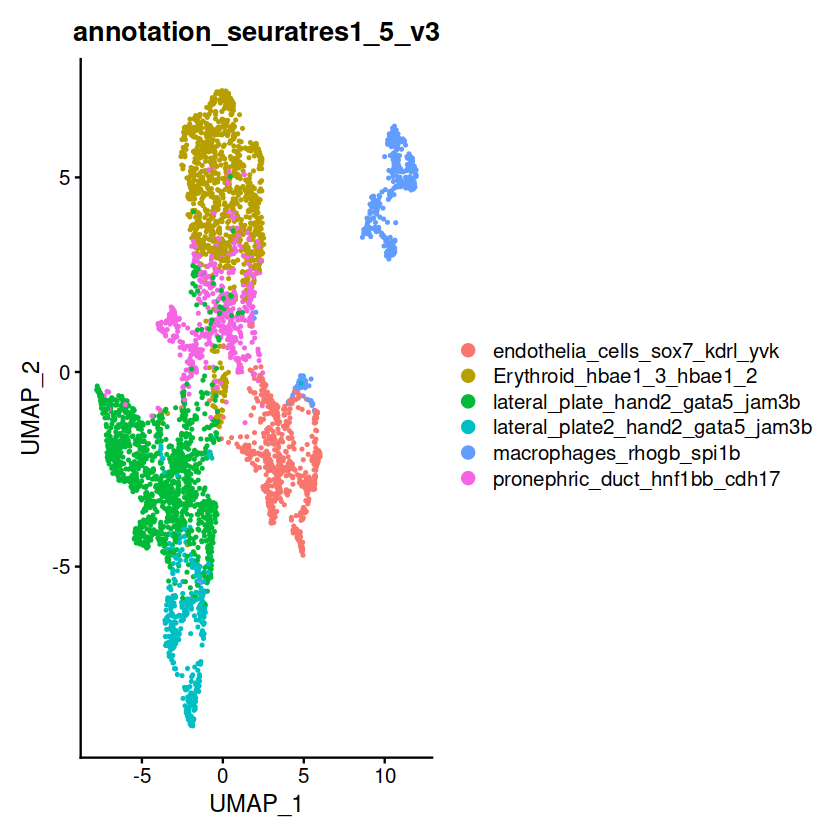

In [23]:
DimPlot(RNB_filtered, dims = c(1, 2), group.by = "annotation_seuratres1_5_v3", repel = TRUE)

## Notes

- This UMAP (post-filtering of somites and pharyngeal arch cells) look a little more sparse than the previous one. Let's try to compute the alignedUMAP for both options (post-filtering, and filtering after the PC coordinates were computed).

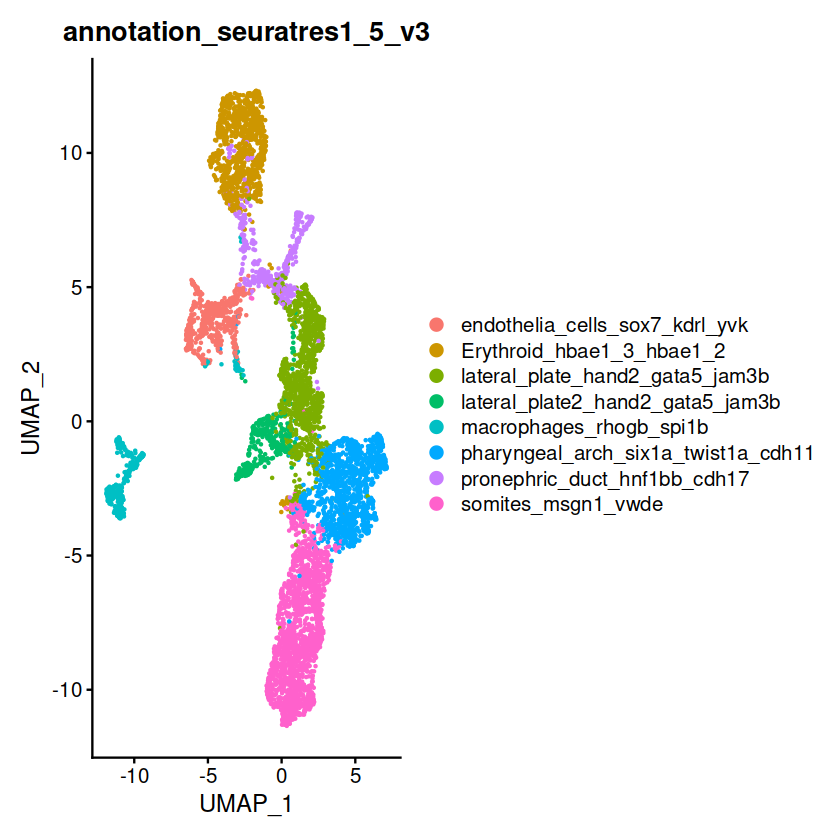

In [40]:
DimPlot(RNB.combined, dims = c(1, 2), group.by = "annotation_seuratres1_5_v3", repel = TRUE)

In [24]:
SaveH5Seurat(RNB_filtered, filename = "RNB_filtered_integrated.h5Seurat")
Convert("RNB_filtered_integrated.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from integrated as X

Adding data from integrated as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding integrated_snn as neighbors



In [53]:
RNB.combined@meta.data %>% head()

,seurat_clusters_res1.5,seqrun,leiden_v6_r0.32,leiden_v5_r0.35,annotation_seuratres1_5_v3,integrated_snn_res.0.5,orig.ident,fish_n,global_annotation,leiden_v11_r0.22,⋯,annotation_umapv2_recluster,timepoint,leiden_v1_r1,leiden_v8_r0.31,X10X_run,annotation_umapv2_global,leiden_v9_r0.31,leiden_v7_r0.3,nCount_RNA,nFeature_RNA
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
TDR43_TCAGGGCTCTTGCGCT-1,25,1,24,24,endothelia_cells_sox7_kdrl_yvk,3,TDR43,43,Epidermal,20,⋯,endothelia_cells_sox7_kdrl_yvk,30somite,26,23,TDR43,hematopoietic cell,23,23,2613.277,3028
TDR44_GAGGCCTCAACAGTGG-1,32,1,8,7,lateral_plate2_hand2_gata5_jam3b,6,TDR44,44,Adaxial_Cells,10,⋯,lateral_plate_hand2_gata5_jam3b,30somite,48,8,TDR44,lateral_mesoderm,8,7,3253.372,4752
TDR44_TCTATCATCCATCCGT-1,17,1,18,17,Erythroid_hbae1_3_hbae1_2,1,TDR44,44,unassigned,16,⋯,Erythroid_hbae1_3_hbae1_2,30somite,3,18,TDR44,hematopoietic cell,18,18,2542.559,4347
TDR43_GAGCTGCGTCCAGCGT-1,11,1,10,8,pharyngeal_arch_six1a_twist1a_cdh11,0,TDR43,43,unassigned,12,⋯,pharyngeal_arch_six1a_twist1a_cdh11,30somite,30,10,TDR43,pharyngeal arch,10,10,2796.644,3719
TDR44_GGTAACTCATGACAGG-1,11,1,10,8,pharyngeal_arch_six1a_twist1a_cdh11,0,TDR44,44,unassigned,12,⋯,pharyngeal_arch_six1a_twist1a_cdh11,30somite,36,10,TDR44,pharyngeal arch,10,10,2678.166,3423
TDR46_AAGCGTTTCGAGAGCA-1,17,1,18,17,Erythroid_hbae1_3_hbae1_2,1,TDR46,46,unassigned,16,⋯,Erythroid_hbae1_3_hbae1_2,30somite,3,18,TDR46,hematopoietic cell,18,18,2226.074,3013


In [54]:
RNB.combined@reductions$pca@cell.embeddings %>% head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,⋯,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
TDR43_TCAGGGCTCTTGCGCT-1,-0.9030025,-29.4693608,-14.9519450,11.51991134,-1.6556557,-1.975728,-2.28725994,2.167577,0.1810507,0.8970949,⋯,3.7236305,2.4946425,-0.35798741,-3.1381461,2.0508499,3.1510311,0.22105875,2.4971331,-0.05120889,3.5538115
TDR44_GAGGCCTCAACAGTGG-1,7.3601619,0.4682123,-0.4012053,-13.97177480,-9.4755641,-9.676853,12.68449689,-1.260977,1.0896312,5.8017124,⋯,2.1246532,-0.1206106,-1.40773318,1.8934223,2.7186148,-1.9988484,-2.59492757,-1.6164678,2.68208549,1.5582715
TDR44_TCTATCATCCATCCGT-1,-21.6964530,6.4211278,-6.7954160,-3.37191019,2.1652354,-1.681944,0.11655360,-5.256048,-0.1407627,-4.4317866,⋯,0.2659576,-0.6126104,0.51592131,0.1798631,0.2161443,-0.7850646,0.07011807,0.8752827,0.08553475,-0.8741098
TDR43_GAGCTGCGTCCAGCGT-1,5.8353768,3.7980407,2.2814425,1.52951785,7.7939678,-2.711280,5.30352256,11.658978,-4.0424532,-3.2813478,⋯,0.9270541,-0.7690192,-0.57194444,-0.2488304,-0.7403445,0.2320512,-0.13706174,0.1869514,-0.71262344,0.7226052
TDR44_GGTAACTCATGACAGG-1,0.7033198,6.1471513,-2.6610971,-0.07004764,10.5452239,-2.345429,4.31399775,-6.367826,-9.4092601,-2.7488762,⋯,-0.4005926,1.1593858,-2.59378464,1.2804483,-1.2226363,-1.2160771,0.22171163,1.1172309,-1.56278657,0.1356204
TDR46_AAGCGTTTCGAGAGCA-1,-26.7891264,6.2001840,-7.5442520,-4.26963230,0.5770449,-1.987688,0.08408412,-1.747764,1.8214291,-3.2866060,⋯,0.3882752,0.0448054,-0.07891165,0.3468277,1.5090412,0.5444226,-1.21487623,0.2955255,-0.30659576,-0.3295770


In [55]:
df_PCA <- RNB.combined@reductions$pca@cell.embeddings
df_PCA %>% head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,⋯,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
TDR43_TCAGGGCTCTTGCGCT-1,-0.9030025,-29.4693608,-14.9519450,11.51991134,-1.6556557,-1.975728,-2.28725994,2.167577,0.1810507,0.8970949,⋯,3.7236305,2.4946425,-0.35798741,-3.1381461,2.0508499,3.1510311,0.22105875,2.4971331,-0.05120889,3.5538115
TDR44_GAGGCCTCAACAGTGG-1,7.3601619,0.4682123,-0.4012053,-13.97177480,-9.4755641,-9.676853,12.68449689,-1.260977,1.0896312,5.8017124,⋯,2.1246532,-0.1206106,-1.40773318,1.8934223,2.7186148,-1.9988484,-2.59492757,-1.6164678,2.68208549,1.5582715
TDR44_TCTATCATCCATCCGT-1,-21.6964530,6.4211278,-6.7954160,-3.37191019,2.1652354,-1.681944,0.11655360,-5.256048,-0.1407627,-4.4317866,⋯,0.2659576,-0.6126104,0.51592131,0.1798631,0.2161443,-0.7850646,0.07011807,0.8752827,0.08553475,-0.8741098
TDR43_GAGCTGCGTCCAGCGT-1,5.8353768,3.7980407,2.2814425,1.52951785,7.7939678,-2.711280,5.30352256,11.658978,-4.0424532,-3.2813478,⋯,0.9270541,-0.7690192,-0.57194444,-0.2488304,-0.7403445,0.2320512,-0.13706174,0.1869514,-0.71262344,0.7226052
TDR44_GGTAACTCATGACAGG-1,0.7033198,6.1471513,-2.6610971,-0.07004764,10.5452239,-2.345429,4.31399775,-6.367826,-9.4092601,-2.7488762,⋯,-0.4005926,1.1593858,-2.59378464,1.2804483,-1.2226363,-1.2160771,0.22171163,1.1172309,-1.56278657,0.1356204
TDR46_AAGCGTTTCGAGAGCA-1,-26.7891264,6.2001840,-7.5442520,-4.26963230,0.5770449,-1.987688,0.08408412,-1.747764,1.8214291,-3.2866060,⋯,0.3882752,0.0448054,-0.07891165,0.3468277,1.5090412,0.5444226,-1.21487623,0.2955255,-0.30659576,-0.3295770


In [56]:
unique(RNB.combined@meta.data$timepoint)

[1] "30somite"   "10somite"   "15somite"   "05somite"   "20somite"  
[6] "0 budstage"

In [25]:
setwd("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_renangioblast/PCA_projection_seurat_filtered/")

In [62]:
RNB.combined@meta.data[RNB.combined@meta.data$timepoint == selected_timepoint, ] %>% head()

,seurat_clusters_res1.5,seqrun,leiden_v6_r0.32,leiden_v5_r0.35,annotation_seuratres1_5_v3,integrated_snn_res.0.5,orig.ident,fish_n,global_annotation,leiden_v11_r0.22,⋯,annotation_umapv2_recluster,timepoint,leiden_v1_r1,leiden_v8_r0.31,X10X_run,annotation_umapv2_global,leiden_v9_r0.31,leiden_v7_r0.3,nCount_RNA,nFeature_RNA
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
TDR26_CGGAATTAGCATTGAA-1,12,1,8,7,lateral_plate_hand2_gata5_jam3b,8,TDR26,26,Lateral_Mesoderm,10,⋯,lateral_plate_hand2_gata5_jam3b,0 budstage,41,8,TDR26,lateral_mesoderm,8,7,3380.260,5106
TDR25_AGACCCGGTCAAATCC-1,28,1,31,30,pronephric_duct_hnf1bb_cdh17,8,TDR25,25,Lateral_Mesoderm,26,⋯,pronephric_duct_hnf1bb_cdh17,0 budstage,49,29,TDR25,intermediate_mesoderm,29,30,3233.628,4209
TDR25_ACTCCCATCTCACTCG-1,28,1,31,30,pronephric_duct_hnf1bb_cdh17,8,TDR25,25,Lateral_Mesoderm,10,⋯,lateral_plate_hand2_gata5_jam3b,0 budstage,41,8,TDR25,lateral_mesoderm,8,7,3106.247,3977
TDR24_TAACTTCCAGAGATTA-1,28,1,31,30,pronephric_duct_hnf1bb_cdh17,8,TDR24,24,Lateral_Mesoderm,26,⋯,pronephric_duct_hnf1bb_cdh17,0 budstage,49,29,TDR24,intermediate_mesoderm,29,30,3372.556,5089
TDR25_TCTTAGTTCTTCTGTA-1,11,1,10,8,pharyngeal_arch_six1a_twist1a_cdh11,0,TDR25,25,Somites,12,⋯,pharyngeal_arch_six1a_twist1a_cdh11,0 budstage,30,10,TDR25,pharyngeal arch,10,10,3456.936,4860
TDR25_TGTGTGACAGACTCTA-1,28,1,31,30,pronephric_duct_hnf1bb_cdh17,8,TDR25,25,Lateral_Mesoderm,26,⋯,pronephric_duct_hnf1bb_cdh17,0 budstage,49,29,TDR25,intermediate_mesoderm,29,30,3190.366,4724


In [27]:
# extract the PCs
df_PCA <- RNB_filtered@reductions$pca@cell.embeddings
df_PCA %>% head()

# subsetting for the timepoint
timepoints <- unique(RNB_filtered@meta.data$timepoint)

for (stage in timepoints){
    selected_timepoint <- stage
    # Extract cell_ids from Seurat object that correspond to the selected timepoint
    selected_cells <- rownames(RNB_filtered@meta.data[RNB_filtered@meta.data$timepoint == selected_timepoint, ])
    # save the subsetted metadata dataframe
    df_metadata <- RNB_filtered@meta.data[RNB_filtered@meta.data$timepoint == selected_timepoint, ]
    metadata_filename <- paste0("nmps_meta_", stage, ".csv")
    write.csv(df_metadata, file=metadata_filename, row.names=TRUE)

    # Subset the dataframe based on these cell_ids
    subset_pc_df <- df_PCA[selected_cells, ]

    # Check the first few rows of the subsetted dataframe
    head(subset_pc_df)
    csv_filename <- paste0("nmps_global_", stage, ".csv")
    write.csv(subset_pc_df, file=csv_filename, row.names=TRUE)
}

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,⋯,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
TDR43_TCAGGGCTCTTGCGCT-1,12.561558,22.097688,-13.496865,1.975515,2.15603561,2.0313681,0.6861960,-3.31959798,-0.02974439,2.0857840,⋯,1.7576906,-0.5898388,-0.6441151,-1.08618566,-0.5462941,-4.69527583,2.2684631,1.8006466,-2.0835763,0.2273710
TDR44_GAGGCCTCAACAGTGG-1,11.499840,-9.939081,5.420882,11.484597,0.06104542,-3.1635765,4.6988650,14.90250203,-16.17178861,-4.7958721,⋯,0.3082422,1.4893869,0.1829325,3.73143526,0.4421616,-2.02645674,-2.2957212,-2.6145915,-1.5061208,-1.9442137
TDR44_TCTATCATCCATCCGT-1,-16.870533,-3.981222,-3.611208,1.017474,1.74772790,-5.1317361,-1.8443796,2.69661678,5.56393342,0.2587339,⋯,1.1854723,-1.3728153,0.3389816,1.07135320,-1.0079001,-0.42417927,0.2509582,1.3749869,0.4577590,-0.9042801
TDR46_AAGCGTTTCGAGAGCA-1,-20.889329,-2.245308,-3.912532,4.338529,1.91548845,-2.0007086,-2.8061671,-0.07705149,4.04087178,2.8287051,⋯,0.3387211,0.3947955,-0.2280788,0.54140033,0.1430385,-0.84259617,0.3432491,0.4663641,-0.9642273,0.5079556
TDR43_AACGAAAGTGCATTAC-1,-19.915712,-1.594248,-4.379196,2.812071,2.11253496,-2.3288220,-2.2358966,-3.73115717,-6.21947641,-0.1133287,⋯,0.1769163,-0.1928938,1.5101562,-0.24366427,-0.1320042,0.01648981,-0.2774813,-0.7989679,-0.2064714,-0.1407917
TDR46_GGGCCATCACTCCGAG-1,-5.647473,29.590864,35.108196,-5.595060,3.51999502,0.8432039,0.5459913,-1.37244938,-3.19619442,-2.0030617,⋯,-0.2077431,1.1311491,2.2811627,-0.09731055,-1.9092518,-0.10696959,0.7827008,-0.0387037,-0.2394238,0.1292847
